In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage import data, io, filters, segmentation, color
from skimage.io import imread_collection

In [2]:
#read data

images_collection = imread_collection('data/*')
num_of_images=len(images_collection)
images = []
for (image,i) in zip (images_collection,range(1,num_of_images+1)):
    if image.shape[0] < image.shape[1]:
        image = np.rot90(image)
    images.append(image)
    


In [3]:
# -------------------- A: Brightness Filter ------------------

def brightness(src, b):
    bright = src + b
    bright[bright > 255] = 255
    bright[bright < 0] = 0
    return bright.astype(np.uint8)

# -------------------- B: Contrast Filter --------------------

def contrast(src, a):
    cont = (src * a)
    cont[cont > 255] = 255
    if cont.max() < 255:
        cont[0,0] = 255
    return cont.astype(np.uint8)

# -------------------- C: Threshold Filter -------------------

def threshold(src, t):
    th, dst = cv2.threshold(src, t, 255, cv2.THRESH_BINARY)
    return dst.astype(np.uint8)

# -------------------- D: Gamma Correction filter ------------

def gamma(src, g):
    dst = 255*((src/255)**(1/g))
    return dst.astype(np.uint8)

# -------------------- E: Dilation and Erosion ------------

kernel7 = np.ones((7, 7)).astype(np.uint8)
kernel7[0:2,0:2] = [[0, 0], [0, 1]]
kernel7[0:2,5:7] = [[0, 0], [1, 0]]
kernel7[5:7,0:2] = [[0, 1], [0, 0]]
kernel7[5:7,5:7] = [[1, 0], [0, 0]]
kernel7 = 1 - kernel7

kernel3 = np.zeros((3,3)).astype(np.uint8)
kernel3[1, :] = 1
kernel3[:, 1] = 1

def dilation(image, iter=1, kernel=kernel7):
    dilate = cv2.dilate(image, kernel, iterations=iter)
    return dilate

def erosion(image, iter=1, kernel=kernel7):
    erode = cv2.erode(image, kernel, iterations=iter)
    return erode

def morphological_edges(image, iter=1, outside=True, kernel = kernel3):
    erode = erosion(image, iter, kernel)
    dilate = dilation(image, iter, kernel)

    out = np.array((1,1))
    if outside:
        out = dilate - erode
    else:
        out = erode - dilate
    return out


In [4]:
def clear_margins(image, show_analytics=False):
    

    th_first = 25
    th_second = 175

    out2 = image.copy().astype(np.uint8)
    out3 = image.copy().astype(np.uint8)
    out3*=0

    canny_edge = cv2.Canny(erosion(dilation(image, 7), 8), th_first, th_second, apertureSize=3, L2gradient=False)
    canny_edge = dilation(canny_edge, 10)
    lines = cv2.HoughLinesP(canny_edge, 1, np.pi/180, 240,  minLineLength=1300, maxLineGap=100)
    if lines is None or len(lines) < 4:
        return -1
    rel_lines = lines[0:4].copy()
    rel_lines *= 0
    rel_lines -= 1

    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if np.abs(y1-y2) < 75: 
            cv2.line(out3, (x1, y1), (x2, y2), (255, 0, 0), 3)
            if (y1 < 1000):
                x1_, y1_, x2_, y2_ = rel_lines[0][0]
                if(y1 > y1_ or y1_ == -1):
                    rel_lines[0] = line
            elif (y1 > image.shape[0]-1000):
                x1_, y1_, x2_, y2_ = rel_lines[1][0]
                if(y1 < y1_ or y1_ == -1):
                    rel_lines[1] = line  
        if (np.abs(x1-x2) < 75):
            cv2.line(out3, (x1, y1), (x2, y2), (255, 0, 0), 3)
            if (x1 < 500):
                x1_, y1_, x2_, y2_ = rel_lines[2][0]
                if(x1 > x1_ or x1_ == -1):
                    rel_lines[2] = line
            elif (x1 > image.shape[1]-500):
                x1_, y1_, x2_, y2_ = rel_lines[3][0]
                if(x1 < x1_ or x1_ == -1):
                    rel_lines[3] = line 


    

    x1_, y1_, x2_, y2_ = rel_lines[0][0]
    out2[:y1_, :] = 255
    x1_, y1_, x2_, y2_ = rel_lines[1][0]
    out2[y1_:, :] = 255
    x1_, y1_, x2_, y2_ = rel_lines[2][0]
    out2[:, :x1_] = 255
    x1_, y1_, x2_, y2_ = rel_lines[3][0]
    out2[:, x1_:] = 255

    if show_analytics:
        plt.figure(figsize=(30, 30))
        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap="gray")

        plt.subplot(2, 2, 2)
        plt.imshow(canny_edge, cmap="gray")

        plt.subplot(2, 2, 3)
        plt.imshow(out3, cmap="gray")

        plt.subplot(2, 2, 4)
        plt.imshow(np.bitwise_or(image, out2), cmap="gray")


    return out2

In [5]:
cleared_margin = []

for (image,i) in zip (images,range(1,num_of_images+1)):

    th_first = 50
    th_second = 150
    out1 = cv2.Canny(image, th_first, th_second, apertureSize=3, L2gradient=False)
    out1 = dilation(out1, 3)
    res = clear_margins(image)
    cleared_margin.append(res)


In [8]:
def region_filling(image):

    scale_percent = 30 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    kernel3 = np.zeros((3,3)).astype(np.uint8)
    kernel3[1, :] = 1
    kernel3[:, 1] = 1

    h, w = resized.shape
    region_fill = np.zeros((h, w)).astype(np.uint8)
    region_fill[:,0] = 255
    region_fill[0,:] = 255
    region_fill[-1,:] = 255
    region_fill[:,-1] = 255

    dst_invert = np.invert(resized)

    while True:
        tmp = cv2.dilate(region_fill, kernel3, iterations=1)
        tmp = (tmp & dst_invert).astype(np.uint8)
        if np.sum(np.abs(region_fill-tmp)) == 0:
            break
        region_fill = tmp
    region = cv2.resize(region_fill, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_AREA)
    return region

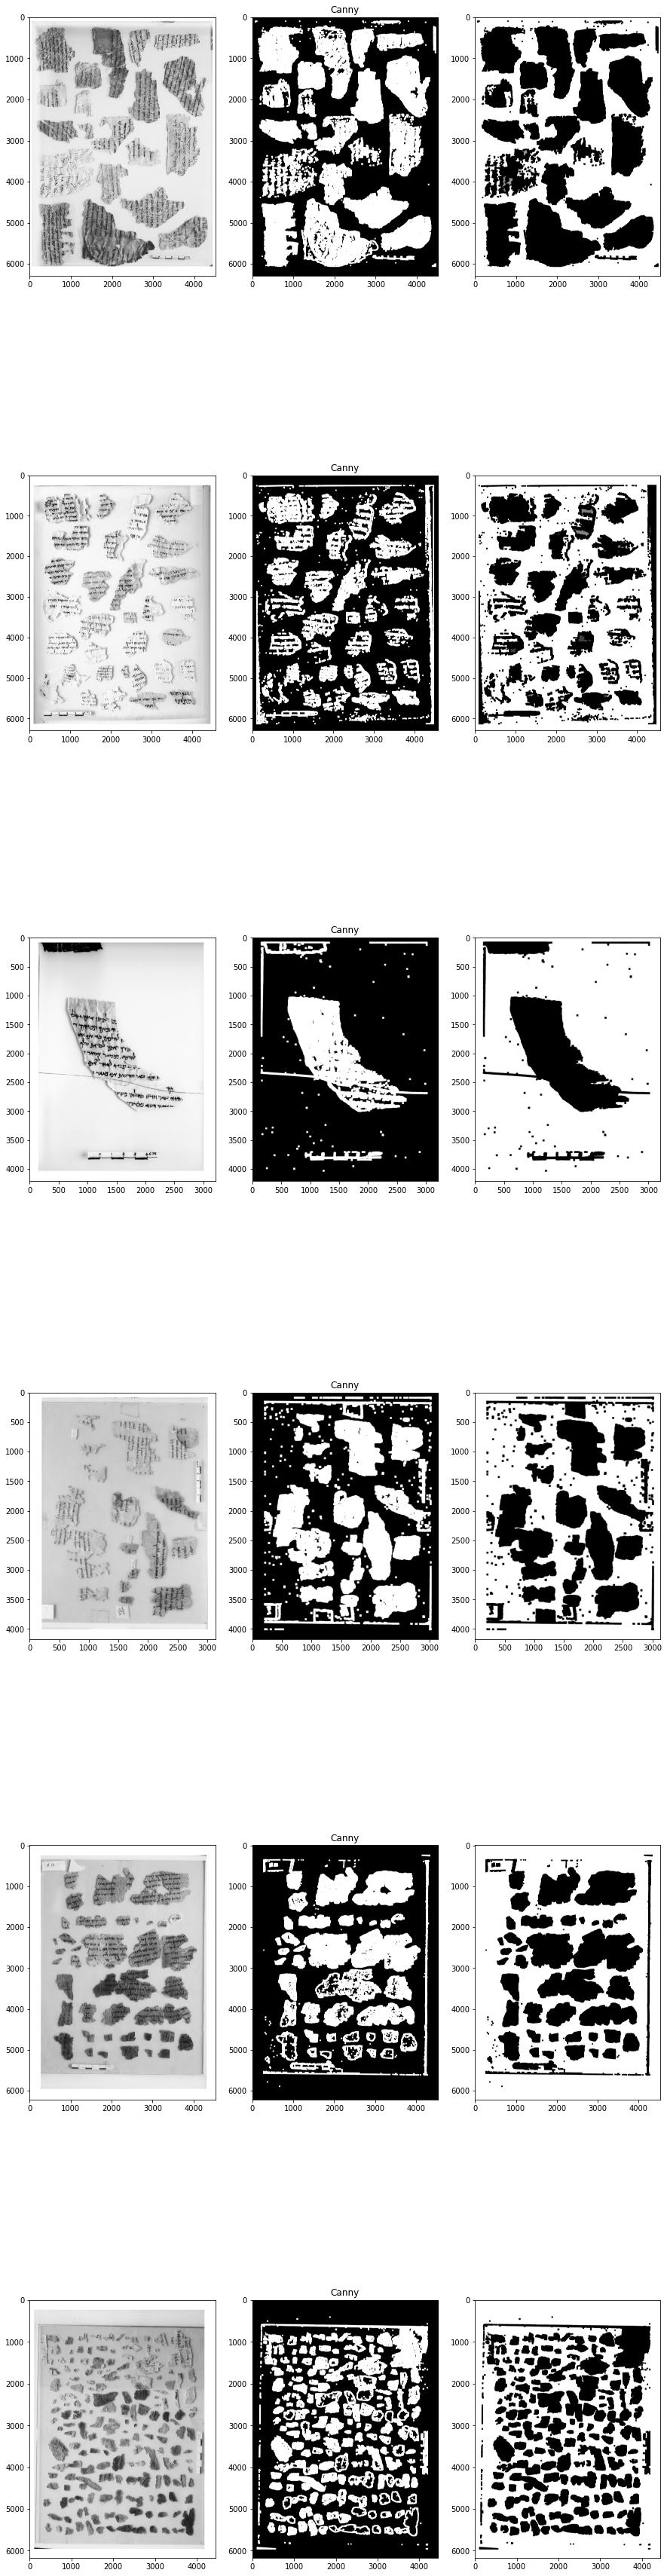

In [15]:



plt.figure(figsize=(15, 65))

edges = []

for i, image in enumerate(cleared_margin):
    
    plt.subplot(int(np.ceil(num_of_images)),3 ,3*i+1)
    plt.imshow(image,cmap='gray')

    res = cv2.GaussianBlur(image, (5,5) , cv2.BORDER_DEFAULT)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(500 ,500))
    res = clahe.apply(res)
    ret3, res = cv2.threshold(res,0,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)
    res = contrast(res, 1.3)
    res = cv2.Canny(res, 0, 45, apertureSize=3, L2gradient=False)
    res = dilation(res, 5)

    plt.subplot(int(np.ceil(num_of_images)),3 ,3*i+2)
    plt.title("Canny")
    plt.imshow(res,cmap='gray')

    plt.subplot(int(np.ceil(num_of_images)),3, 3*i+3)

    region = region_filling(res)

    plt.imshow(region,cmap='gray')
